In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from tqdm import tqdm
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Activation,BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger,ModelCheckpoint,ReduceLROnPlateau
from keras.regularizers import l2
from PIL import Image

Using TensorFlow backend.


In [3]:
ls ../input

sample_submission.csv  test/  train/  train.csv


###### Breif Exploratory Data Analysis

In [4]:
trainDf=pd.read_csv("../input/train.csv")

In [5]:
trainDf.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
trainDf.shape

(17500, 2)

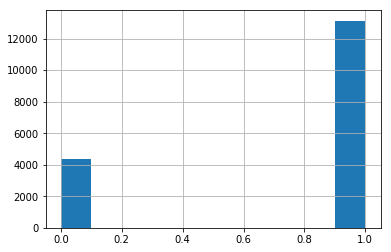

In [7]:
trainDf['has_cactus'].hist()

In [8]:
trainDf['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

As we can see the the number of classes in the train dataset.

###### Now, lets load the dataset and prepare the dataset for the further porcessing

In [9]:
def load_df(dataframe=None,batchSize=16):
    dataframe=trainDf
    if dataframe is None:
        dataframe=pd.read_csv("../input/train.csv")
        
    #The generator takes only string categorical value so converting the categorical value into str
    dataframe['has_cactus']=dataframe['has_cactus'].apply(str) 
    gen=ImageDataGenerator(rescale=1/255,horizontal_flip=True,vertical_flip=True,validation_split=0.1)
    trainGen=gen.flow_from_dataframe(dataframe,directory='../input/train/train',x_col='id',y_col='has_cactus',target_size=(32,32),
                                    class_mode='categorical',batch_size=batchSize,shuffle=True,subset='validation')
    
    testGen=gen.flow_from_dataframe(dataframe,directory='../input/train/train',x_col='id',y_col='has_cactus',target_size=(32,32),
                                    class_mode='categorical',batch_size=batchSize,shuffle=True,subset='validation')
    return trainGen,testGen

In [10]:
# Okay lets load the data 
trainGen,testGen=load_df(batchSize=32)

Found 1750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [12]:
model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32,32,3)))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.0005, decay=1e-5),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [14]:
model.fit_generator(trainGen,steps_per_epoch=5000,epochs=3,validation_data=testGen,validation_steps=500,shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
5000/5000 [==============================] - 148s 30ms/step - loss: 0.0629 - acc: 0.9798 - val_loss: 0.1334 - val_acc: 0.9613
Epoch 2/3
5000/5000 [==============================] - 145s 29ms/step - loss: 0.0253 - acc: 0.9940 - val_loss: 0.5035 - val_acc: 0.9126
Epoch 3/3
5000/5000 [==============================] - 147s 29ms/step - loss: 0.0162 - acc: 0.9962 - val_loss: 0.0229 - val_acc: 0.9955


In [18]:
submission_set=pd.read_csv('../input/sample_submission.csv')

In [19]:
submission_set.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [20]:
submission_set.shape

(4000, 2)

In [21]:
predictions=np.empty((submission_set.shape[0],))
for n in tqdm(range(submission_set.shape[0])):
    data=np.array(Image.open('../input/test/test/'+submission_set.id[n]))
    data=data.astype(np.float32)/255.
    predictions[n]=model.predict(data.reshape((1,32,32,3)))[0][1]

submission_set['has_cactus']=predictions
submission_set.to_csv('sample_submission.csv',index=False)    

100%|██████████| 4000/4000 [00:11<00:00, 362.30it/s]


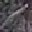

In [22]:
Image.open("../input/test/test/000940378805c44108d287872b2f04ce.jpg")

In [23]:
ls ../input/test/test

000940378805c44108d287872b2f04ce.jpg  7ff6f49dad5c18134b7d1654916aa3bb.jpg
0017242f54ececa4512b4d7937d1e21e.jpg  7ffbc679faca1197297ed482d398a32d.jpg
001ee6d8564003107853118ab87df407.jpg  80068a6a34867ee9628e97f4d1b76ba1.jpg
002e175c3c1e060769475f52182583d0.jpg  803dab8af46e05859e29ad816f381964.jpg
0036e44a7e8f7218e9bc7bf8137e4943.jpg  803e01586525874577631aa1364f3ad6.jpg
0038ed6f7417b8275b393307f66cb1e3.jpg  804291b6c4956b882bf3b2c3a83c0d71.jpg
0059dfa41de4441fc23b9a4b98ba99cb.jpg  80588926c90733190f9d9ff0b3a14db7.jpg
0061bd302d735db829418cb90b4e6040.jpg  8058f00430832af12f1806c86e9ac86a.jpg
00754573d8c7223e73da553dd43780bd.jpg  809691d3d1d670ebf5c2fe2f4a051975.jpg
008d9fce71c8e03a4c9cdd15ea908573.jpg  809fc05c8f3c0b0b0c05dbe2f27e5ff6.jpg
00a36d4d6d152404670276fc983273bc.jpg  80aa21cd464973e4614e6d10533832a5.jpg
00b706122b87e0fa275ff59e39d4d94b.jpg  80af0f1abcabd6a38bde73bfc7a1e37f.jpg
00c054da839d5518e59790f7d867f317.jpg  80c555f6e78597a405416b6c57469613.jpg
00c88441b0510cdb3a6e9b3fa

In [24]:
submission_set.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.000000
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.000001
3,002e175c3c1e060769475f52182583d0.jpg,0.000007
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.964860
